### Patients sub-group detection by PILOT



<div class="alert alert-block alert-info">
<b>PILOT</b>

In this tutorial, we are using single-cell data from pancreatic ductal adenocarcinomas to find sub-groups of patients using clustering of W distances. And then we rank the cells/genes based on clustering results.

* You can download the Anndata (h5ad) file for this tutorial from [here](https://costalab.ukaachen.de/open_data/PILOT/PDAC.h5ad).
</div>

In [1]:
import PILOT as pl
import scanpy as sc

##### Reading Anndata

In [2]:
adata=sc.read_h5ad('PDAC.h5ad')

##### Loading the required information and computing the Wasserstein distance:
<div class="alert alert-block alert-info"> In order to work with PILOT, ensure that your Anndata object is loaded and contains the required information.
    
Use the following parameters to configure PILOT for your analysis (Setting Parameters):
    
adata: Pass your loaded Anndata object to PILOT.
    
emb_matrix: Provide the name of the variable in the obsm level that holds the dimension reduction (PCA representation).
    
clusters_col: Specify the name of the column in the observation level of your Anndata that corresponds to cell types or clusters.
    
sample_col: Indicate the column name in the observation level of your Anndata that contains information about samples or patients.
    
status: Provide the column name that represents the status or disease (e.g., "control" or "case").
       
</div>

In [3]:
pl.tl.wasserstein_distance(adata,emb_matrix='X_pca',
clusters_col='cell_types',sample_col='sampleID',status='status')

##### Ploting the Cost matrix and the Wasserstein distance:
<div class="alert alert-block alert-info"> 
 Here we show the heatmaps of the Cost matrix (cells) and Wasserstein distance (samples).      
</div>

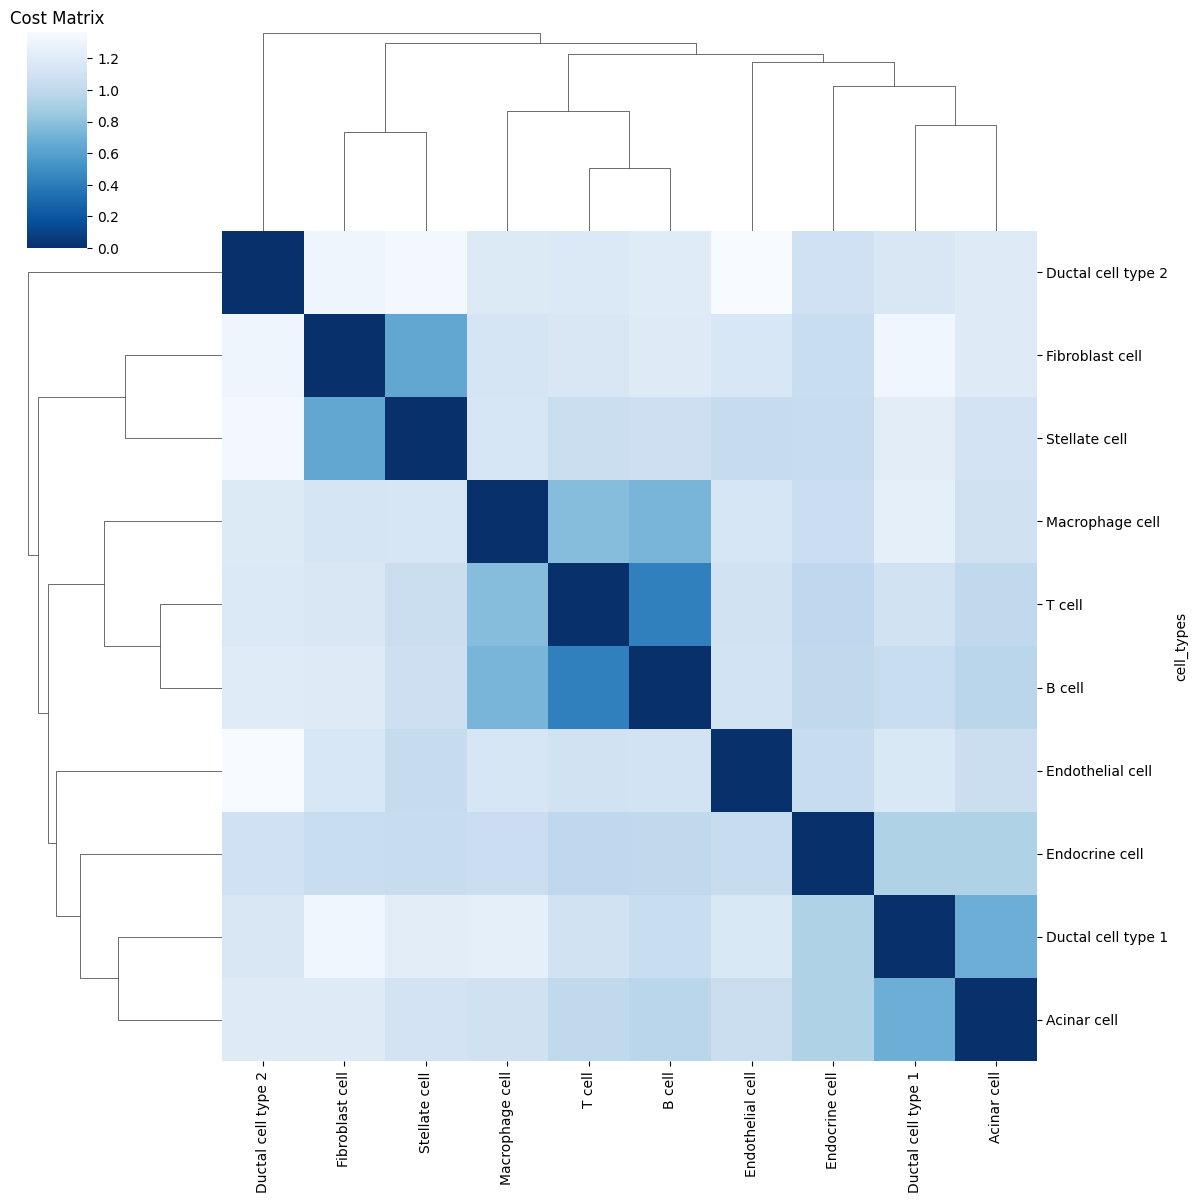

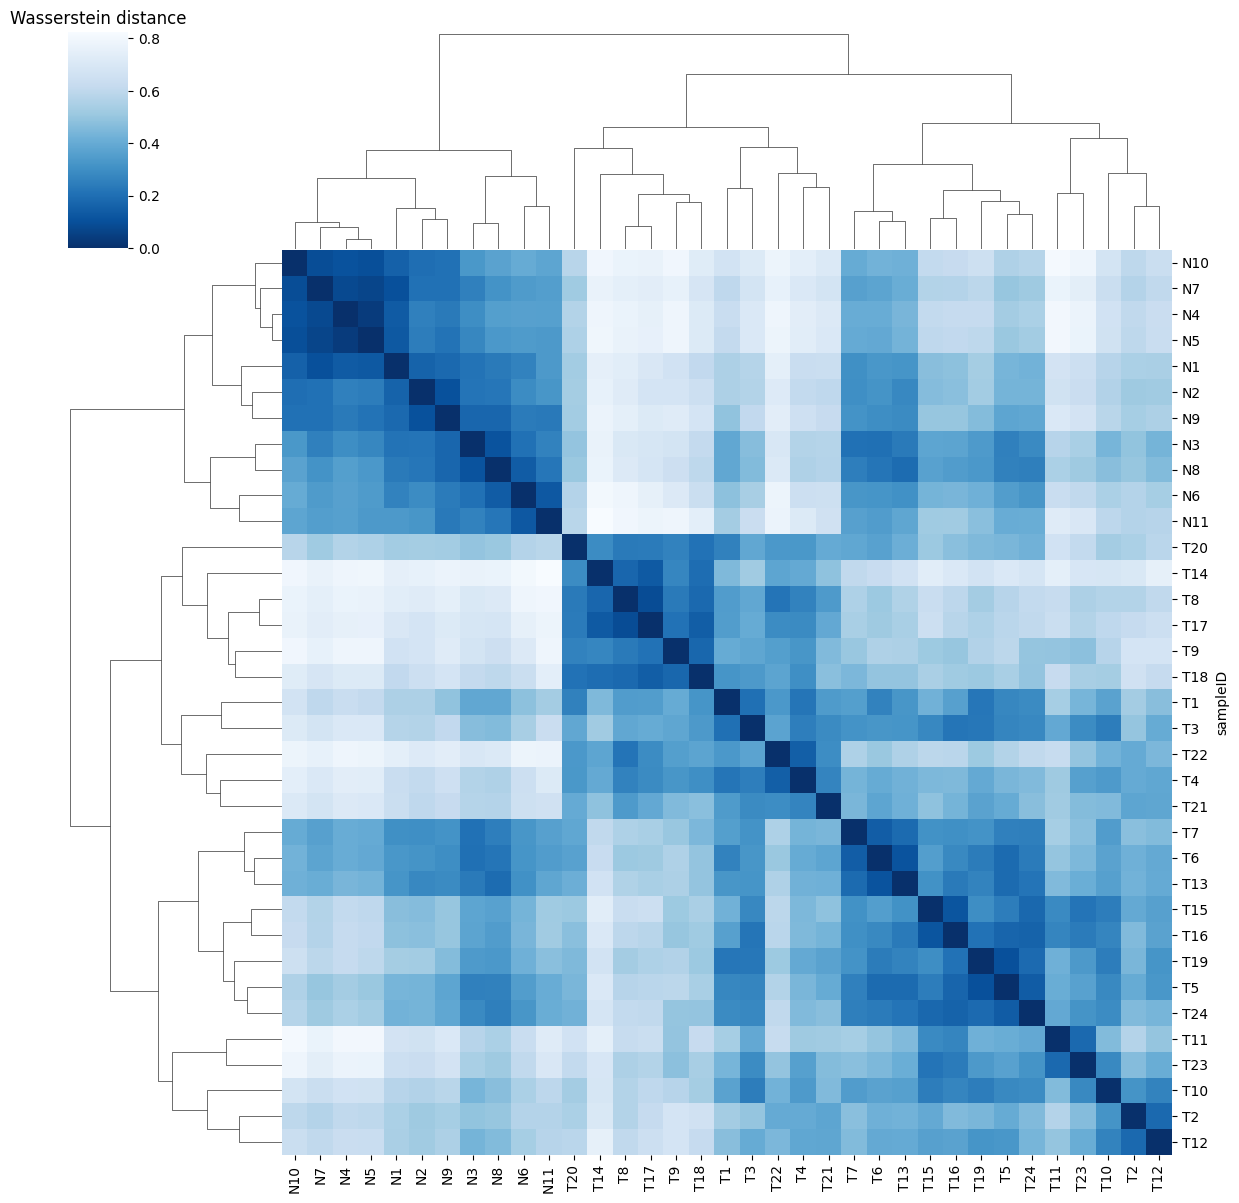

In [4]:
pl.pl.heatmaps(adata)

##### Trajectory:
<div class="alert alert-block alert-info"> 
 Here we show the Diffusion map of Wasserstein distance. In the upcoming trajectory analysis, the labels "T" signify Tumor and "N" indicates the Normal.
</div>

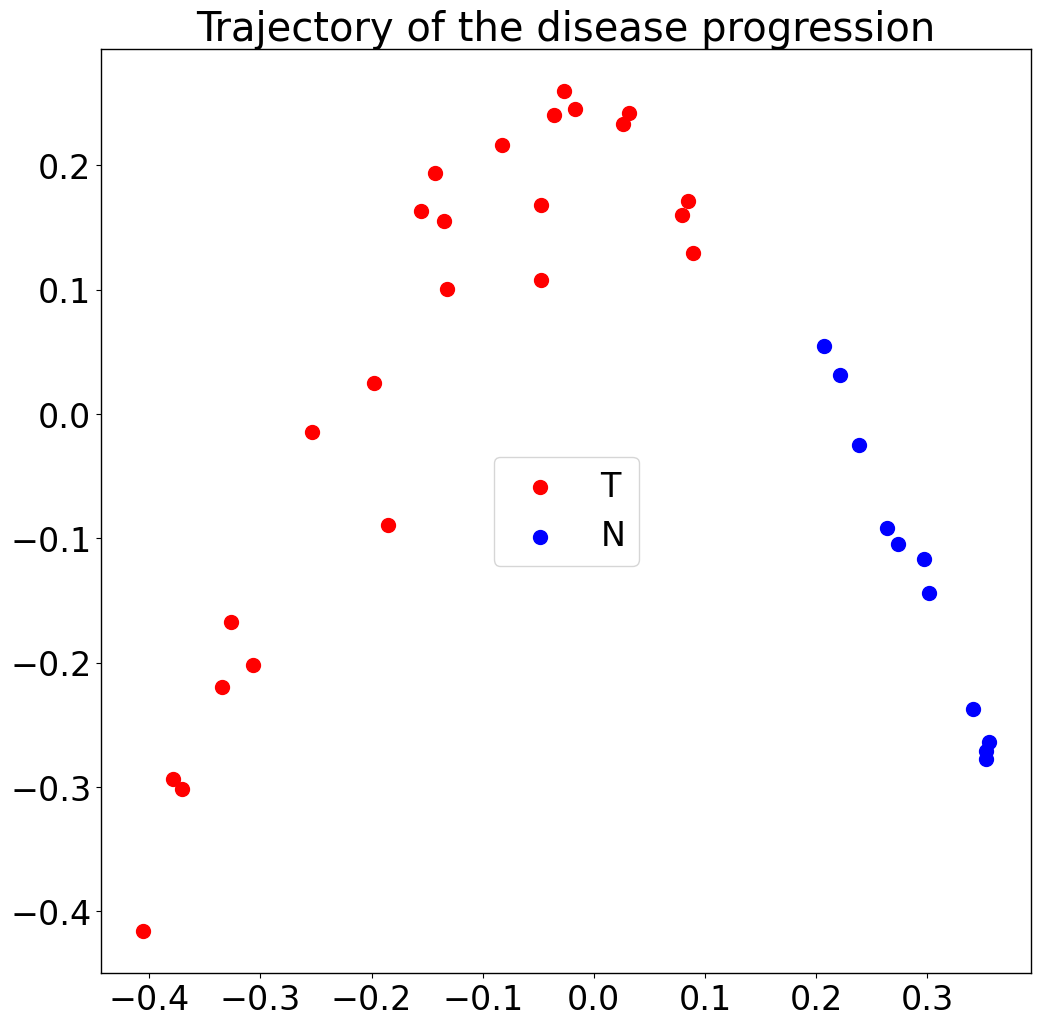

In [5]:
pl.pl.trajectory(adata,colors=['red','Blue'])

##### In this section, we should find the optimal number of clusters. 
<div class="alert alert-block alert-info"> 
The Silhouette Score Curve is used to find the optimal number of clusters by plotting the average Silhouette Score for different numbers of clusters. The number of clusters corresponding to the highest average Silhouette Score is considered the optimal number of clusters.
</div>


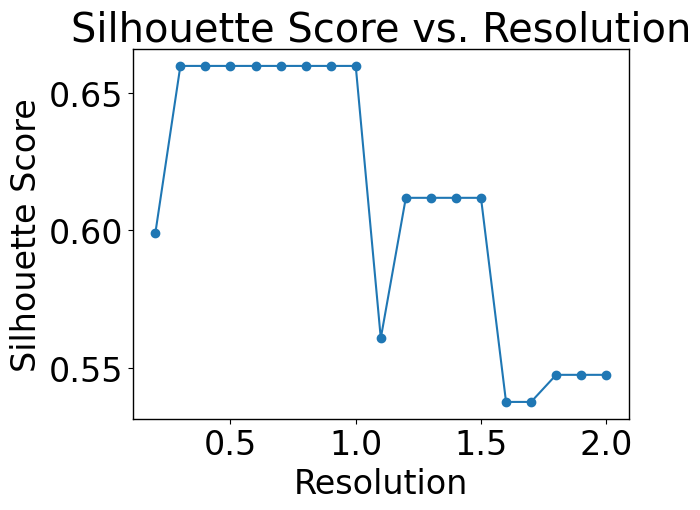

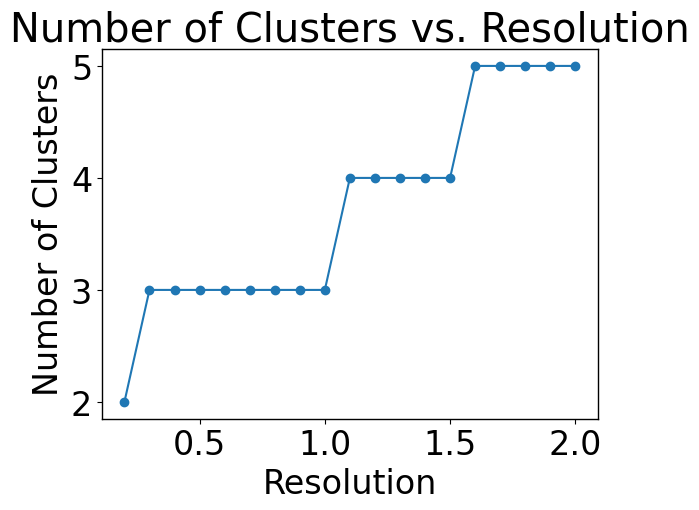

In [6]:
pl.pl.select_best_sil(adata)

##### Patients sub-group detection by clustering EMD. 
<div class="alert alert-block alert-info"> 
Using the Silhouette scores of the previous step, we can find the optimal number of cluster of patients to detect different stage of disease. 
</div>

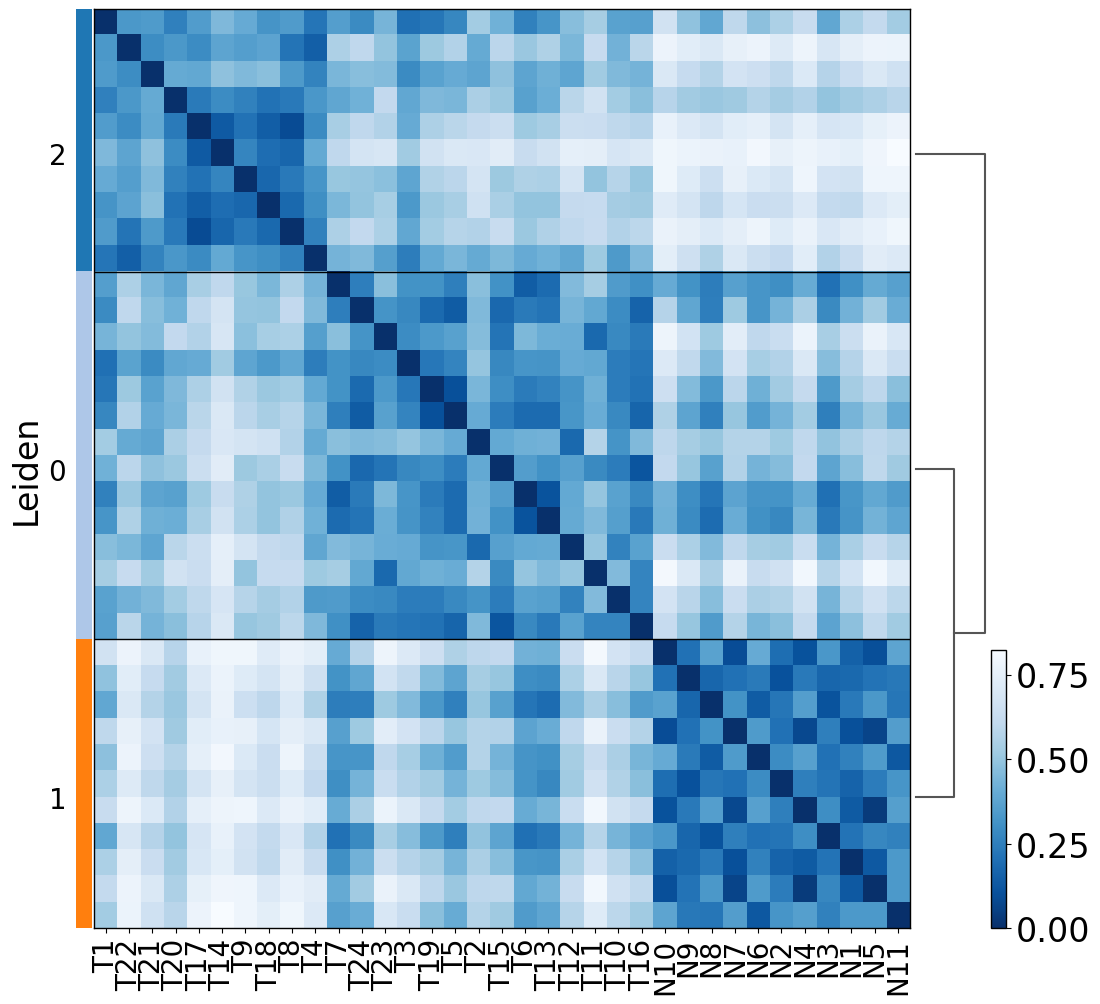

In [7]:
proportion_df=pl.pl.clustering_emd(adata,res=adata.uns['best_res'])

Here we can see that all of the Normal samples are in cluster 1, so we can rename the name of clusters for future analysis. This step is optional!

In [8]:
proportion_df.loc[proportion_df['Predicted_Labels']=='0', 'Predicted_Labels'] = 'Tumor 1'
proportion_df.loc[proportion_df['Predicted_Labels']=='1', 'Predicted_Labels'] = 'Normal'
proportion_df.loc[proportion_df['Predicted_Labels']=='2', 'Predicted_Labels'] = 'Tumor 2'

##### Cell-type selection. 
<div class="alert alert-block alert-info"> 
Importantly, we determine which cell type derives the disease from the first stage to the second stage by detecting cell types have statistically significant changes between two sub-groups. This is done using Welch’s t-test, which is appropriate for unequal variances in two groups of samples.

Based on the adjusted p-value threshold you consider, you can choose how statistically significant the cell types you want to have.
  
</div>

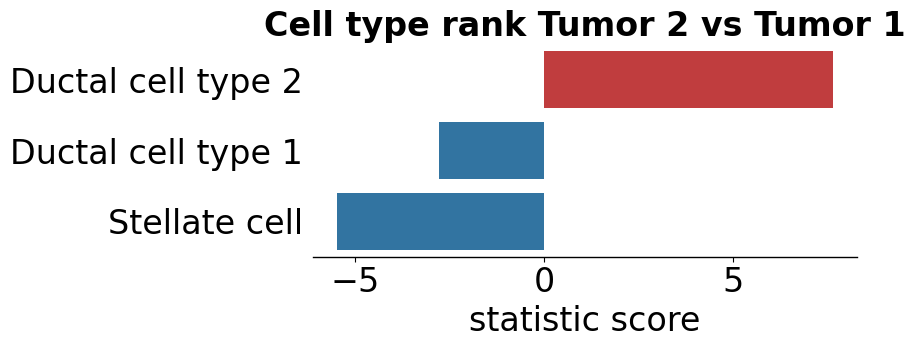

In [9]:
pl.pl.cell_type_diff_two_sub_patient_groups(proportion_df, proportion_df.columns[0:-2],
                                      group1 = 'Tumor 2', group2 = 'Tumor 1',
                                      pval_thr = 0.05, figsize = (15, 4))

<div class="alert alert-block alert-info"> 
Next, we can check the distribution of each patient sub-group in each cell type (the three above ones).
</div>

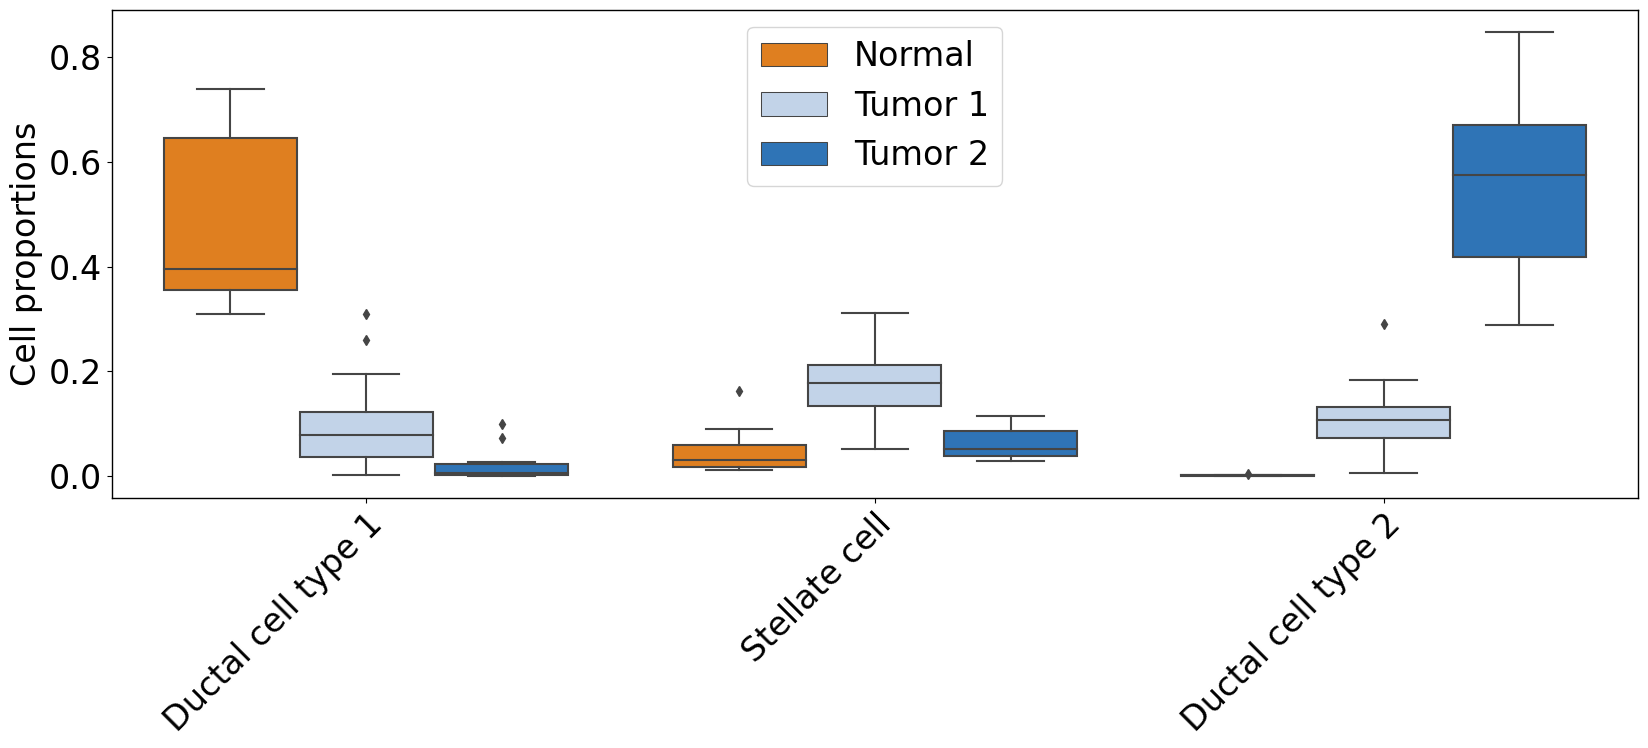

In [10]:
pl.pl.plot_cell_types_distributions(proportion_df, cell_types=['Stellate cell','Ductal cell type 2','Ductal cell type 1'],
                              figsize = (17,8),label_order=['Normal', 'Tumor 1', 'Tumor 2'],label_colors=['#FF7F00','#BCD2EE','#1874CD'])

<div class="alert alert-block alert-info"> 
 We also can check the distribution of each patient sub-group in the whole cell types.
</div>

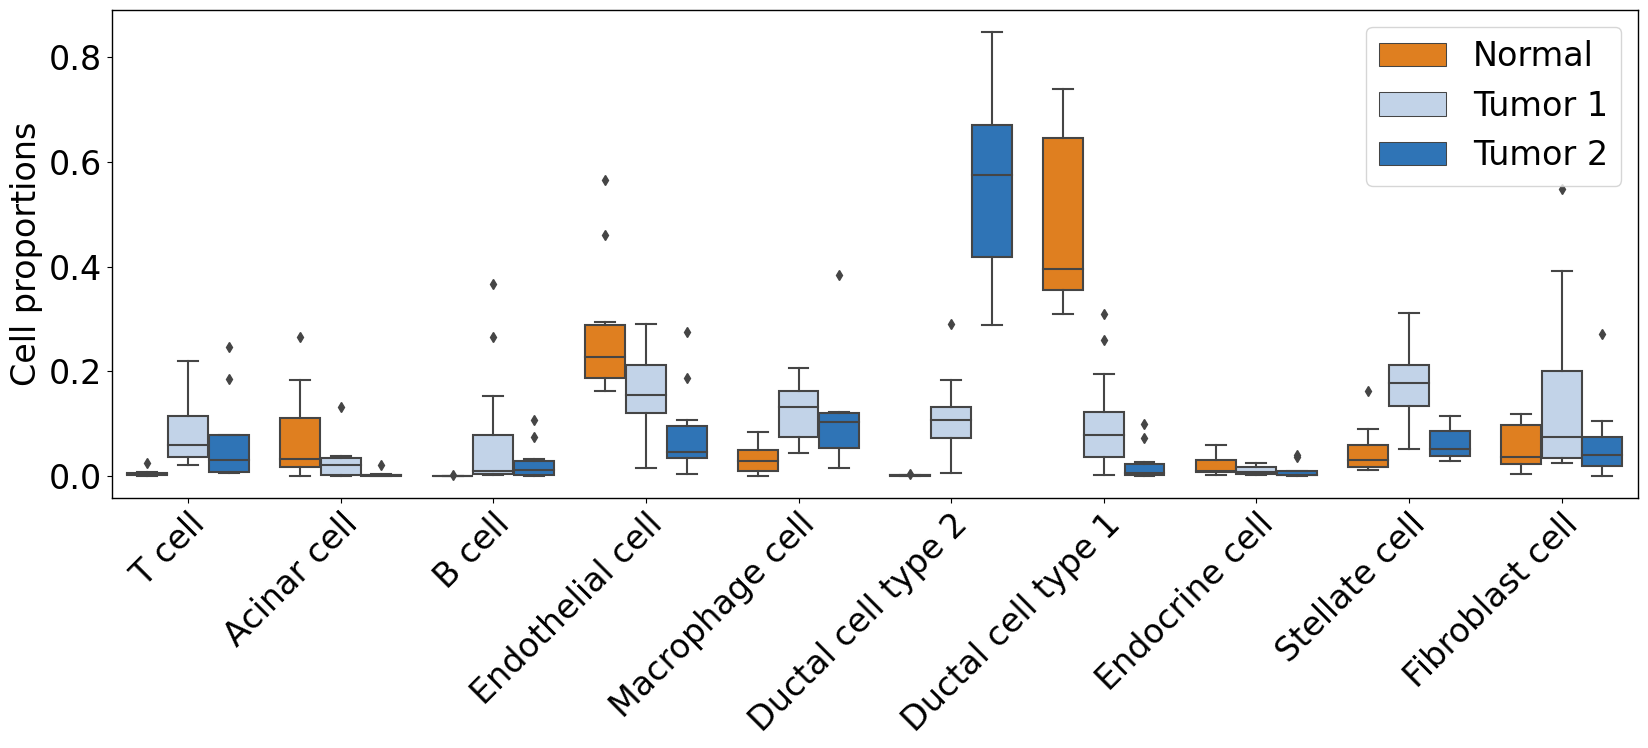

In [11]:
pl.pl.plot_cell_types_distributions(proportion_df, cell_types=list(proportion_df.columns[0:-2]),
                              figsize = (17,8),label_order=['Normal', 'Tumor 1', 'Tumor 2'],label_colors=['#FF7F00','#BCD2EE','#1874CD'])

<div class="alert alert-block alert-info"> 
In the statistical table generated in your results path, all cell types are sorted based on the score and their adjusted p-value.
cell types with positive scores shows the most differences cell types in group 1 compared with group 2 and negative scores shows the other way. 
You can the results in 'Results_PILOT/Diff_Expressions_Results' folder.
</div>

#### Differential expression analysis

##### Note:

<div class="alert alert-block alert-info"> 
This step needs the 'limma' package in R, You need to run this function to install it (if you have not already done)!
</div>

In [12]:
#pl.tl.install_r_packages()

##### Ductal cell type 1

<div class="alert alert-block alert-info"> 
In the next step, for specific cell types, we find the Differential genes between two interested patient sub-groups
Based on the fold change threshold, you can determine how much difference you want to see between two interested patients sub-groups. For the tutorial, we already saved the needed input for this function (2000 highly variable genes for each cell type). 
    
You can run this function for your own data, and it automatically extracts the gene expressions for each cell type ("2000 highly variable genes). In case you want all/more genes, please change the "highly_variable_genes_" or "n_top_genes" parameters.
</div>

run limma lmFit
run limma eBayes


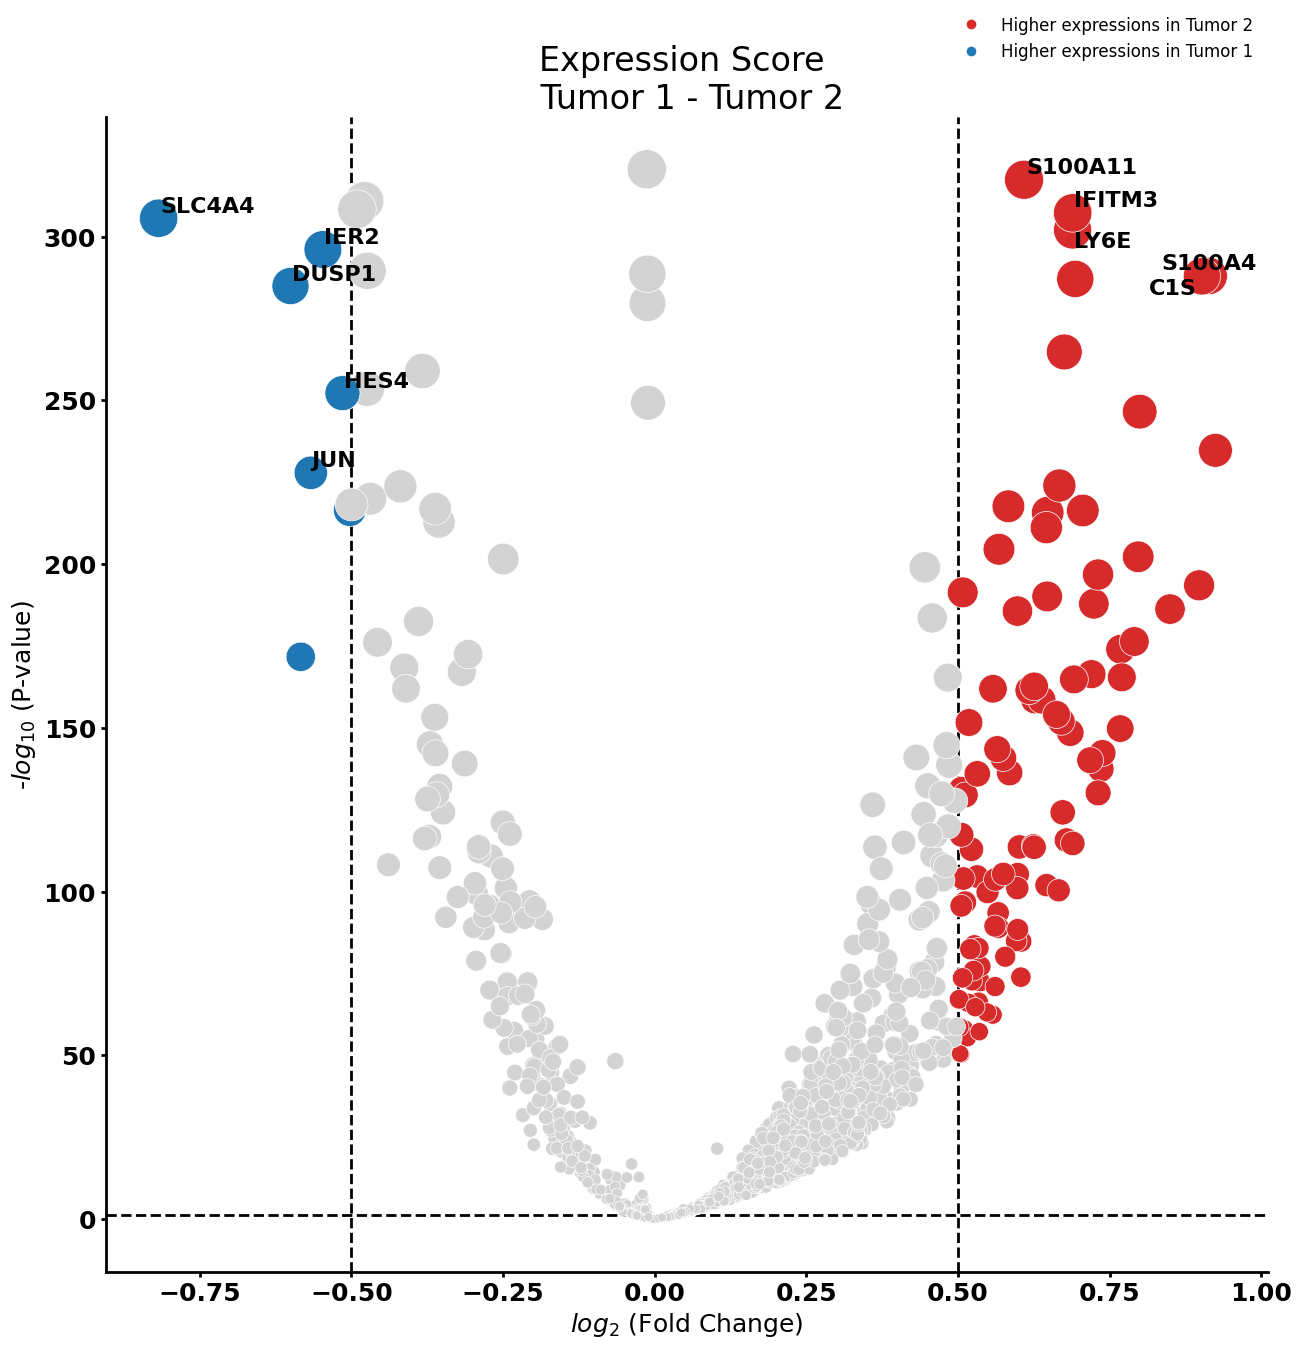

In [13]:
cell_type = "Ductal cell type 1" #look at the Cells folder
pl.tl.compute_diff_expressions(adata,cell_type, proportion_df,
                         fc_thr =  0.5, pval_thr = 0.05,
                         group1 = 'Tumor 1', group2 = 'Tumor 2',sample_col='sampleID',
                               col_cell='cell_types',
                            )

###### Gene Ontology analysis

<div class="alert alert-block alert-info">  Based on the adjusted p-value and fold change threshold, we select genes that are highly differentiated in each patient sub-groups and specify their annotation using the <a href="https://biit.cs.ut.ee/gprofiler/gost">gProfiler</a>
    
</div>

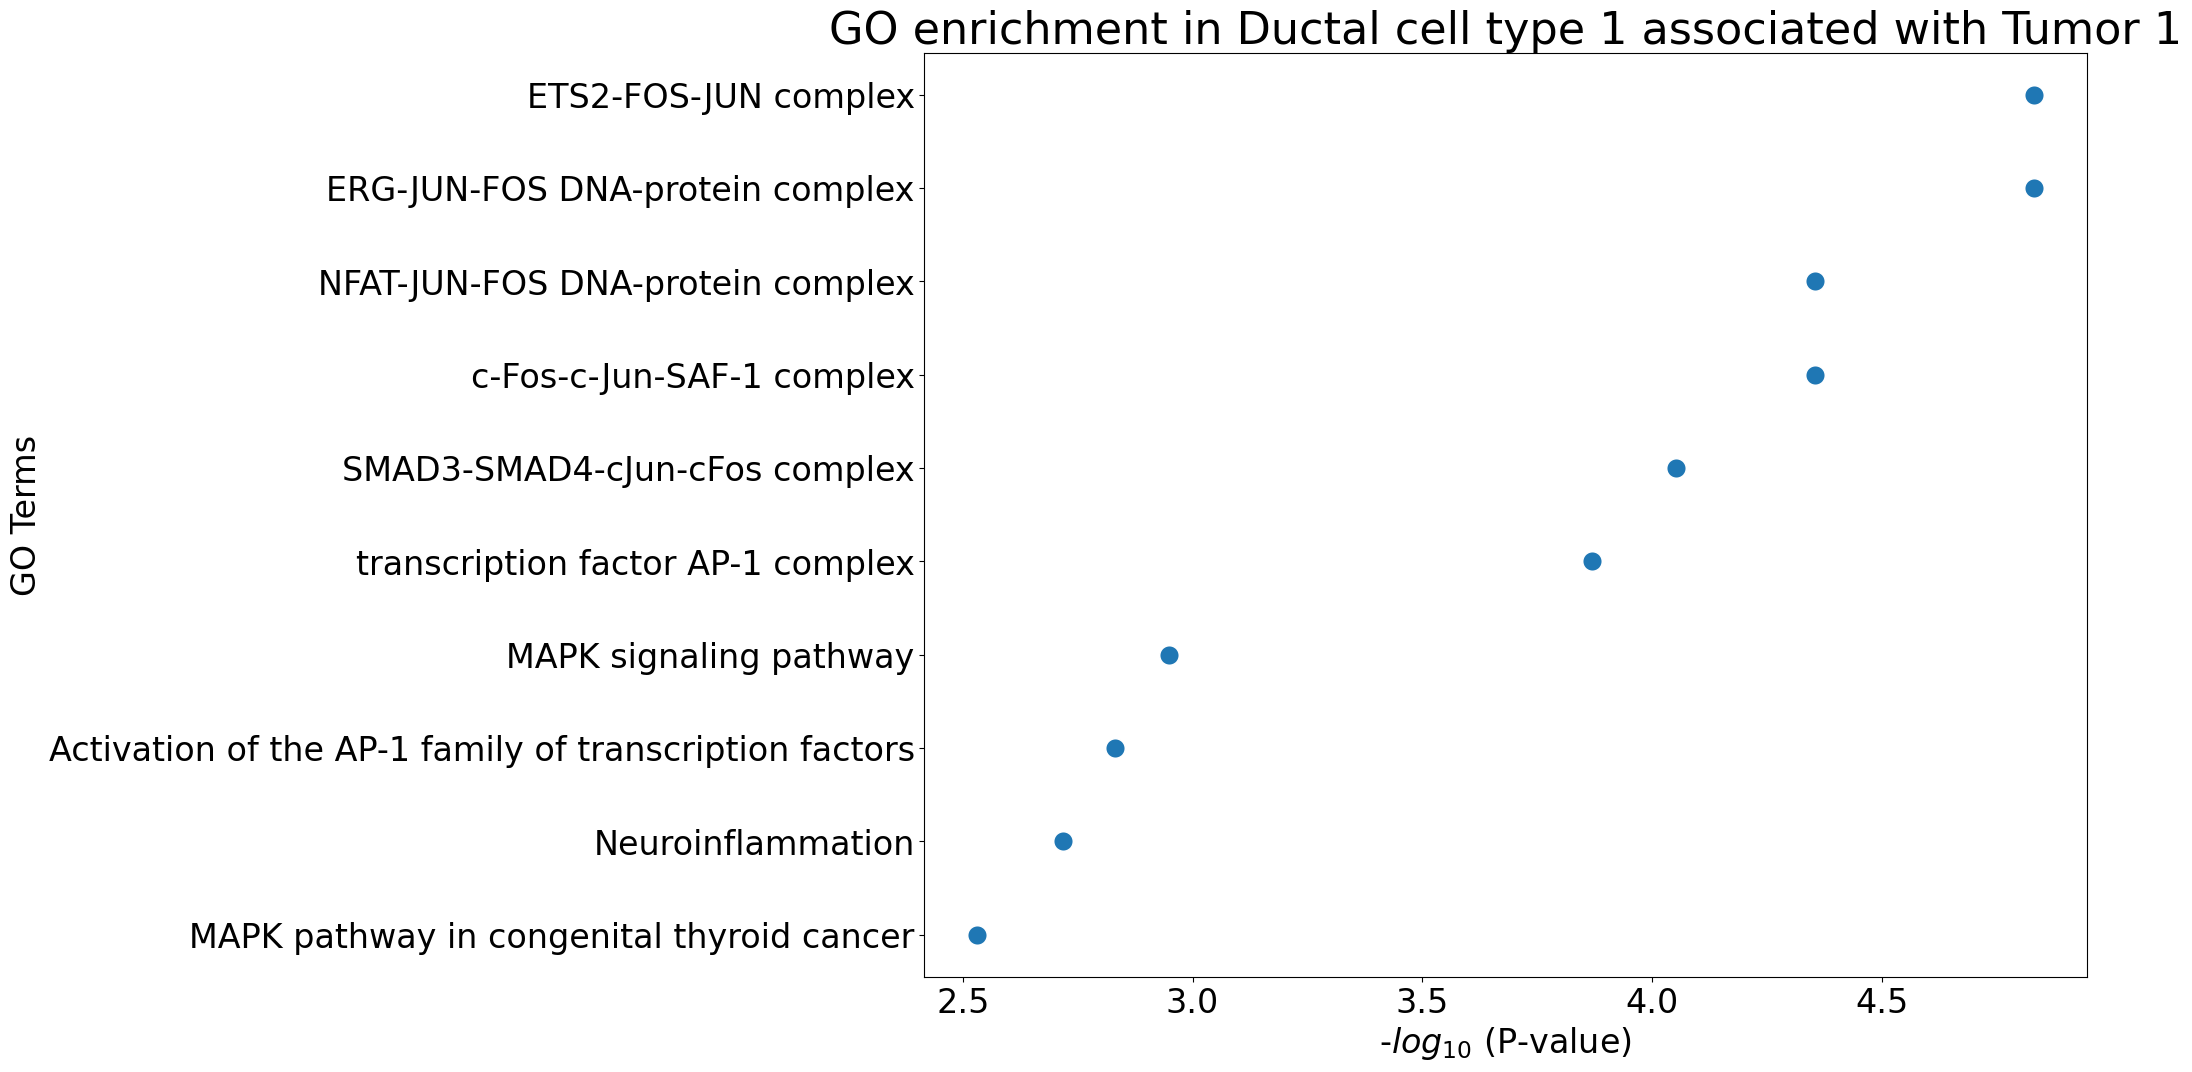

In [14]:
pl.pl.gene_annotation_cell_type_subgroup(cell_type = cell_type, group = 'Tumor 1'
                                   ,num_gos=10)

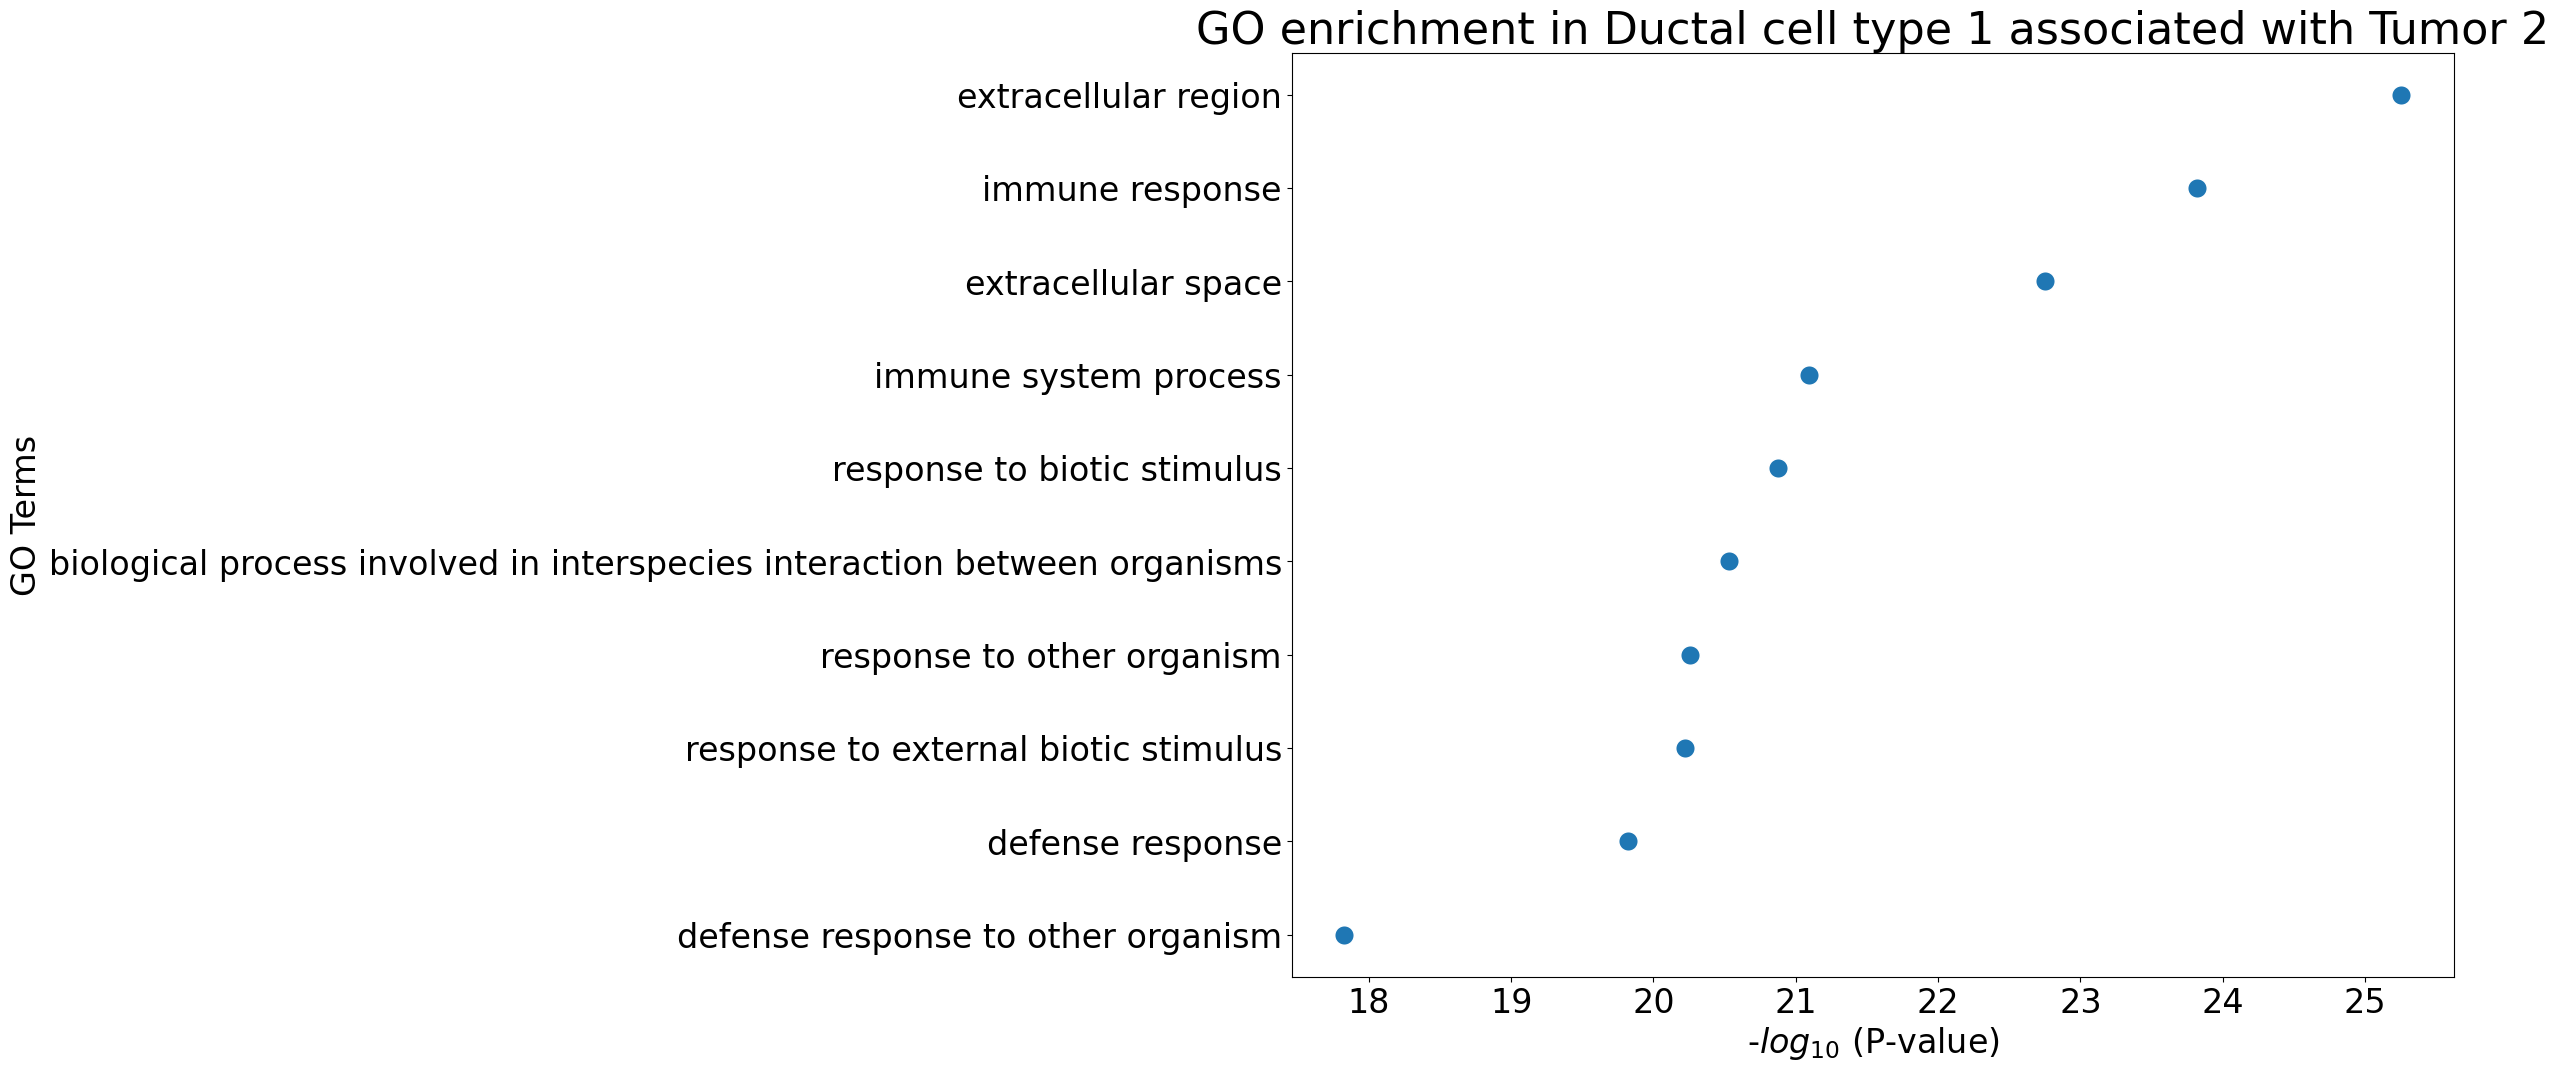

In [15]:
pl.pl.gene_annotation_cell_type_subgroup(cell_type = cell_type, group = 'Tumor 2',
                                   num_gos=10)

##### Stellate cell

run limma lmFit
run limma eBayes


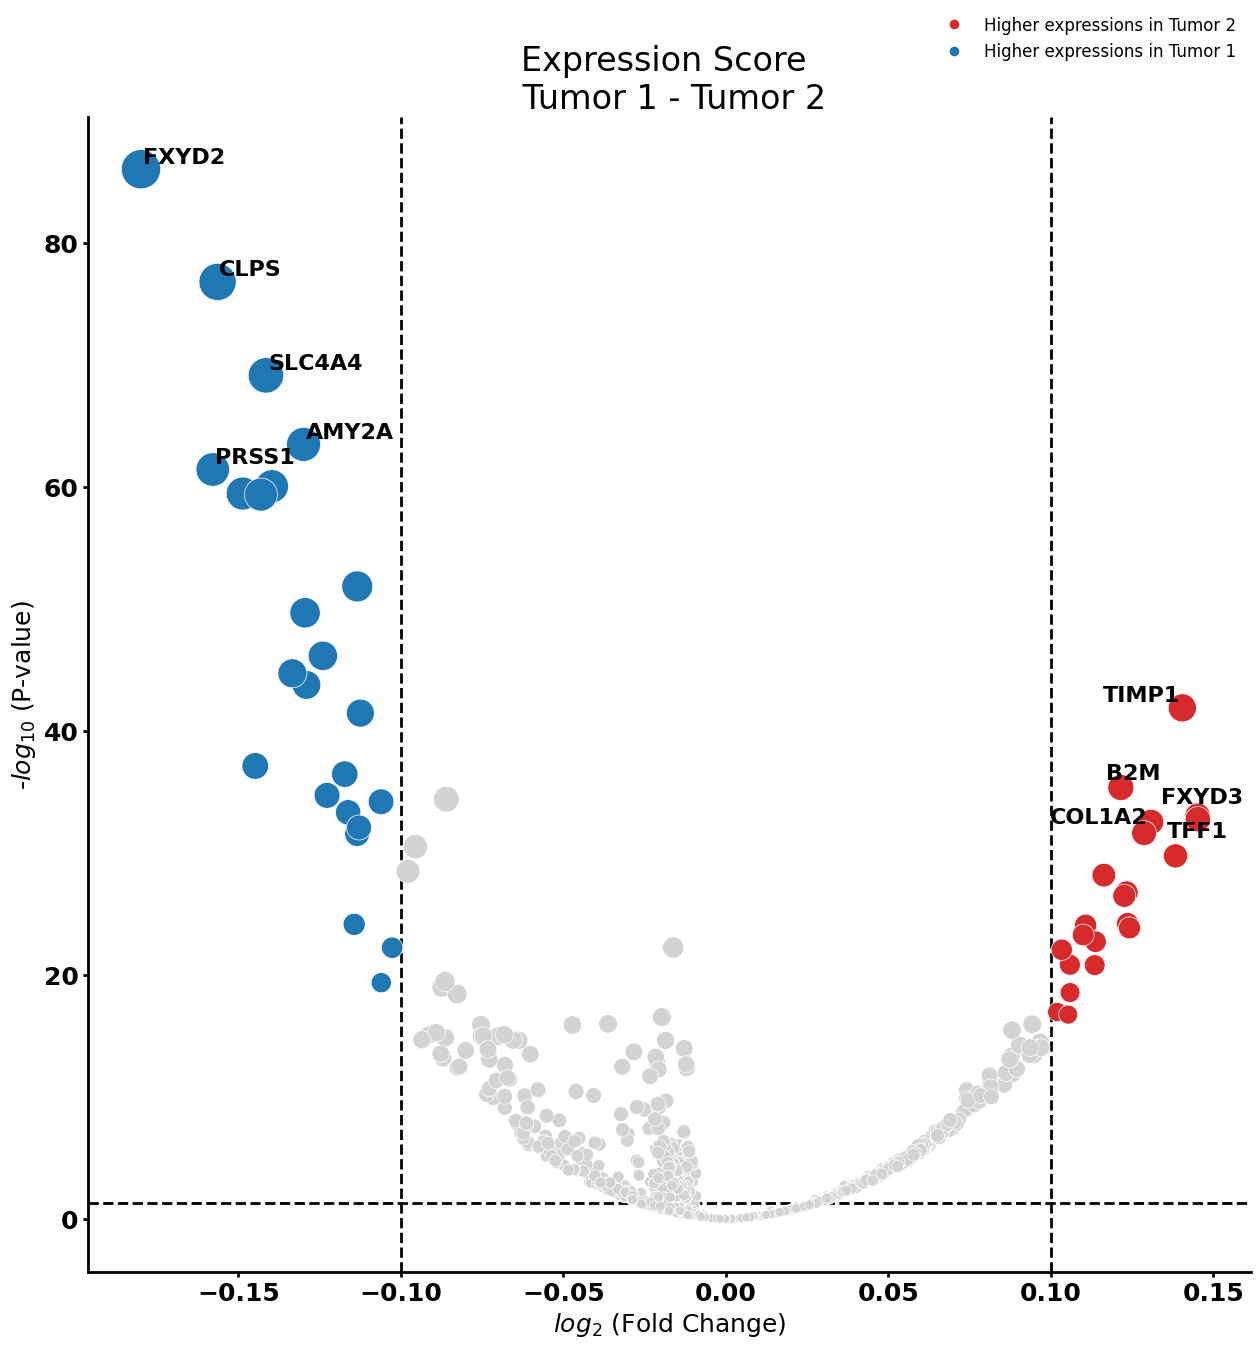

In [16]:
cell_type = "Stellate cell" #look at the Cells folder
pl.tl.compute_diff_expressions(adata,cell_type, proportion_df,
                         fc_thr = 0.1, pval_thr = 0.05,
                         group1 = 'Tumor 1', group2 = 'Tumor 2',sample_col='sampleID',
                               col_cell='cell_types')

###### Gene Ontology analysis

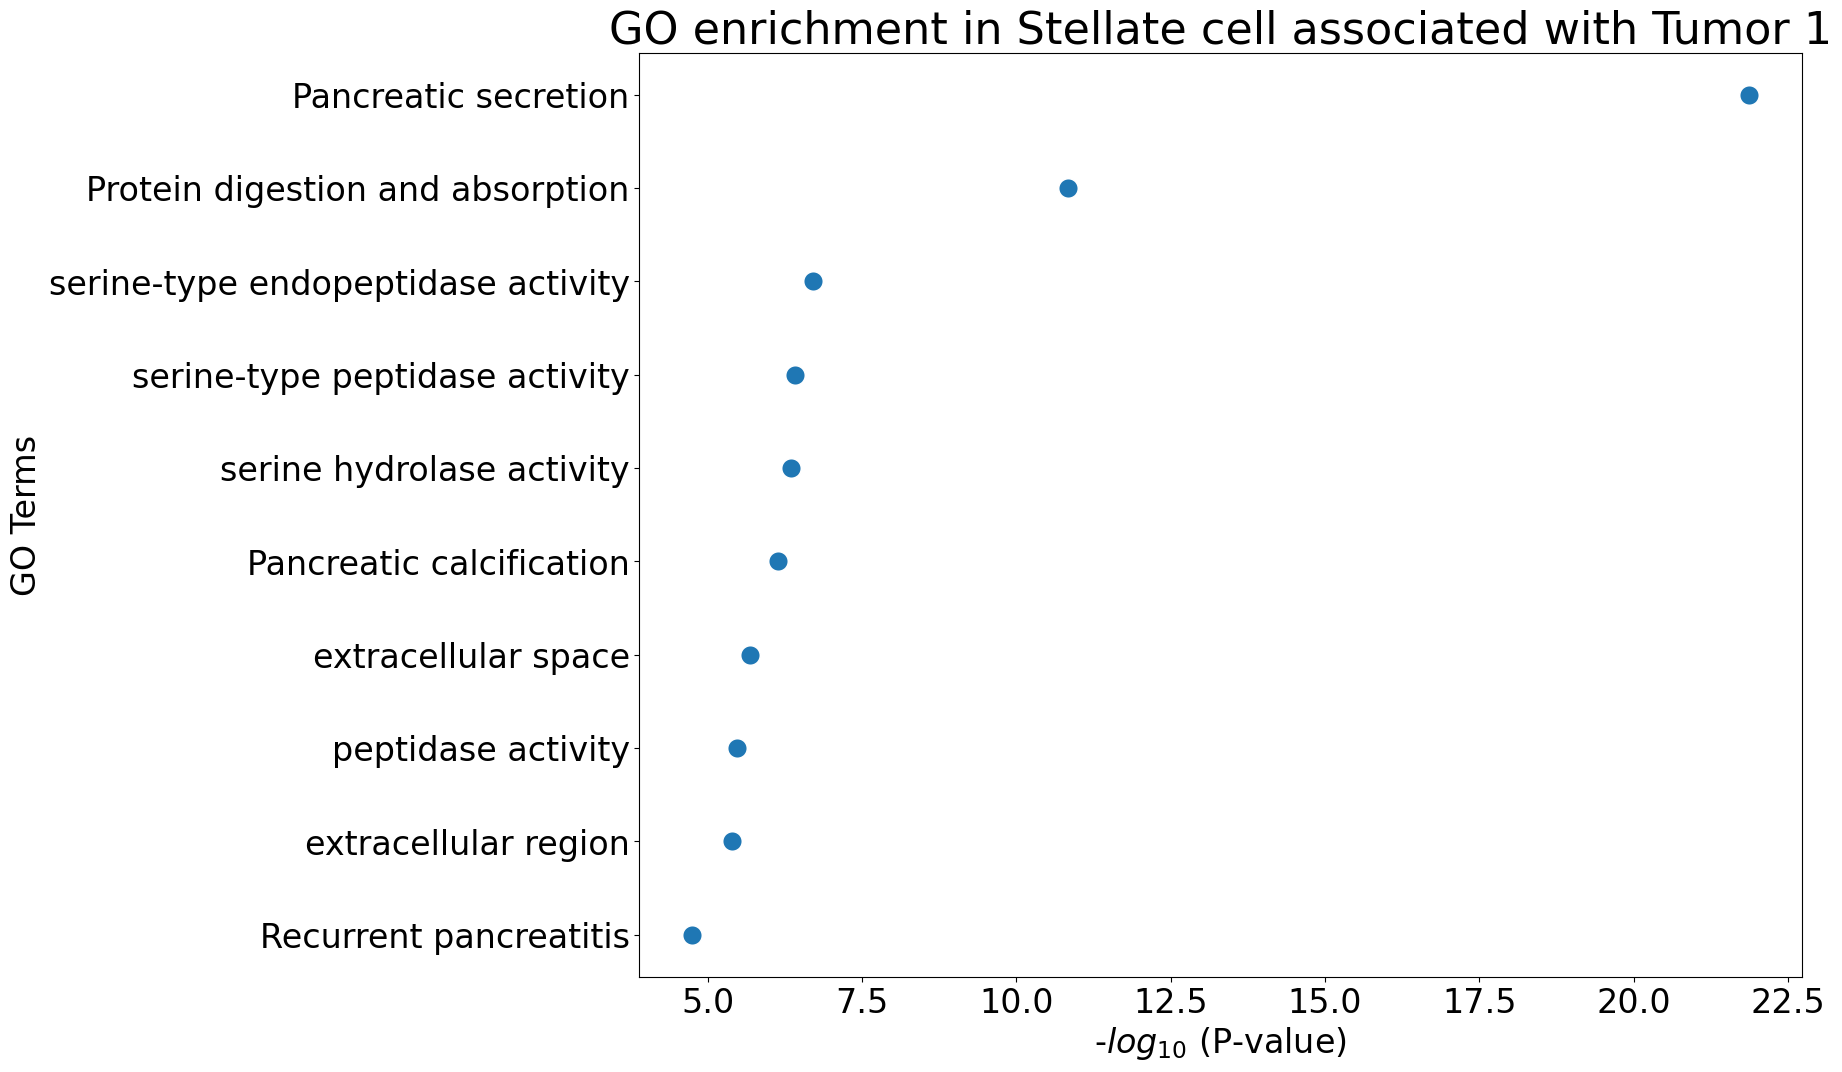

In [17]:
pl.pl.gene_annotation_cell_type_subgroup(cell_type = cell_type, group = 'Tumor 1',
                                   num_gos=10)

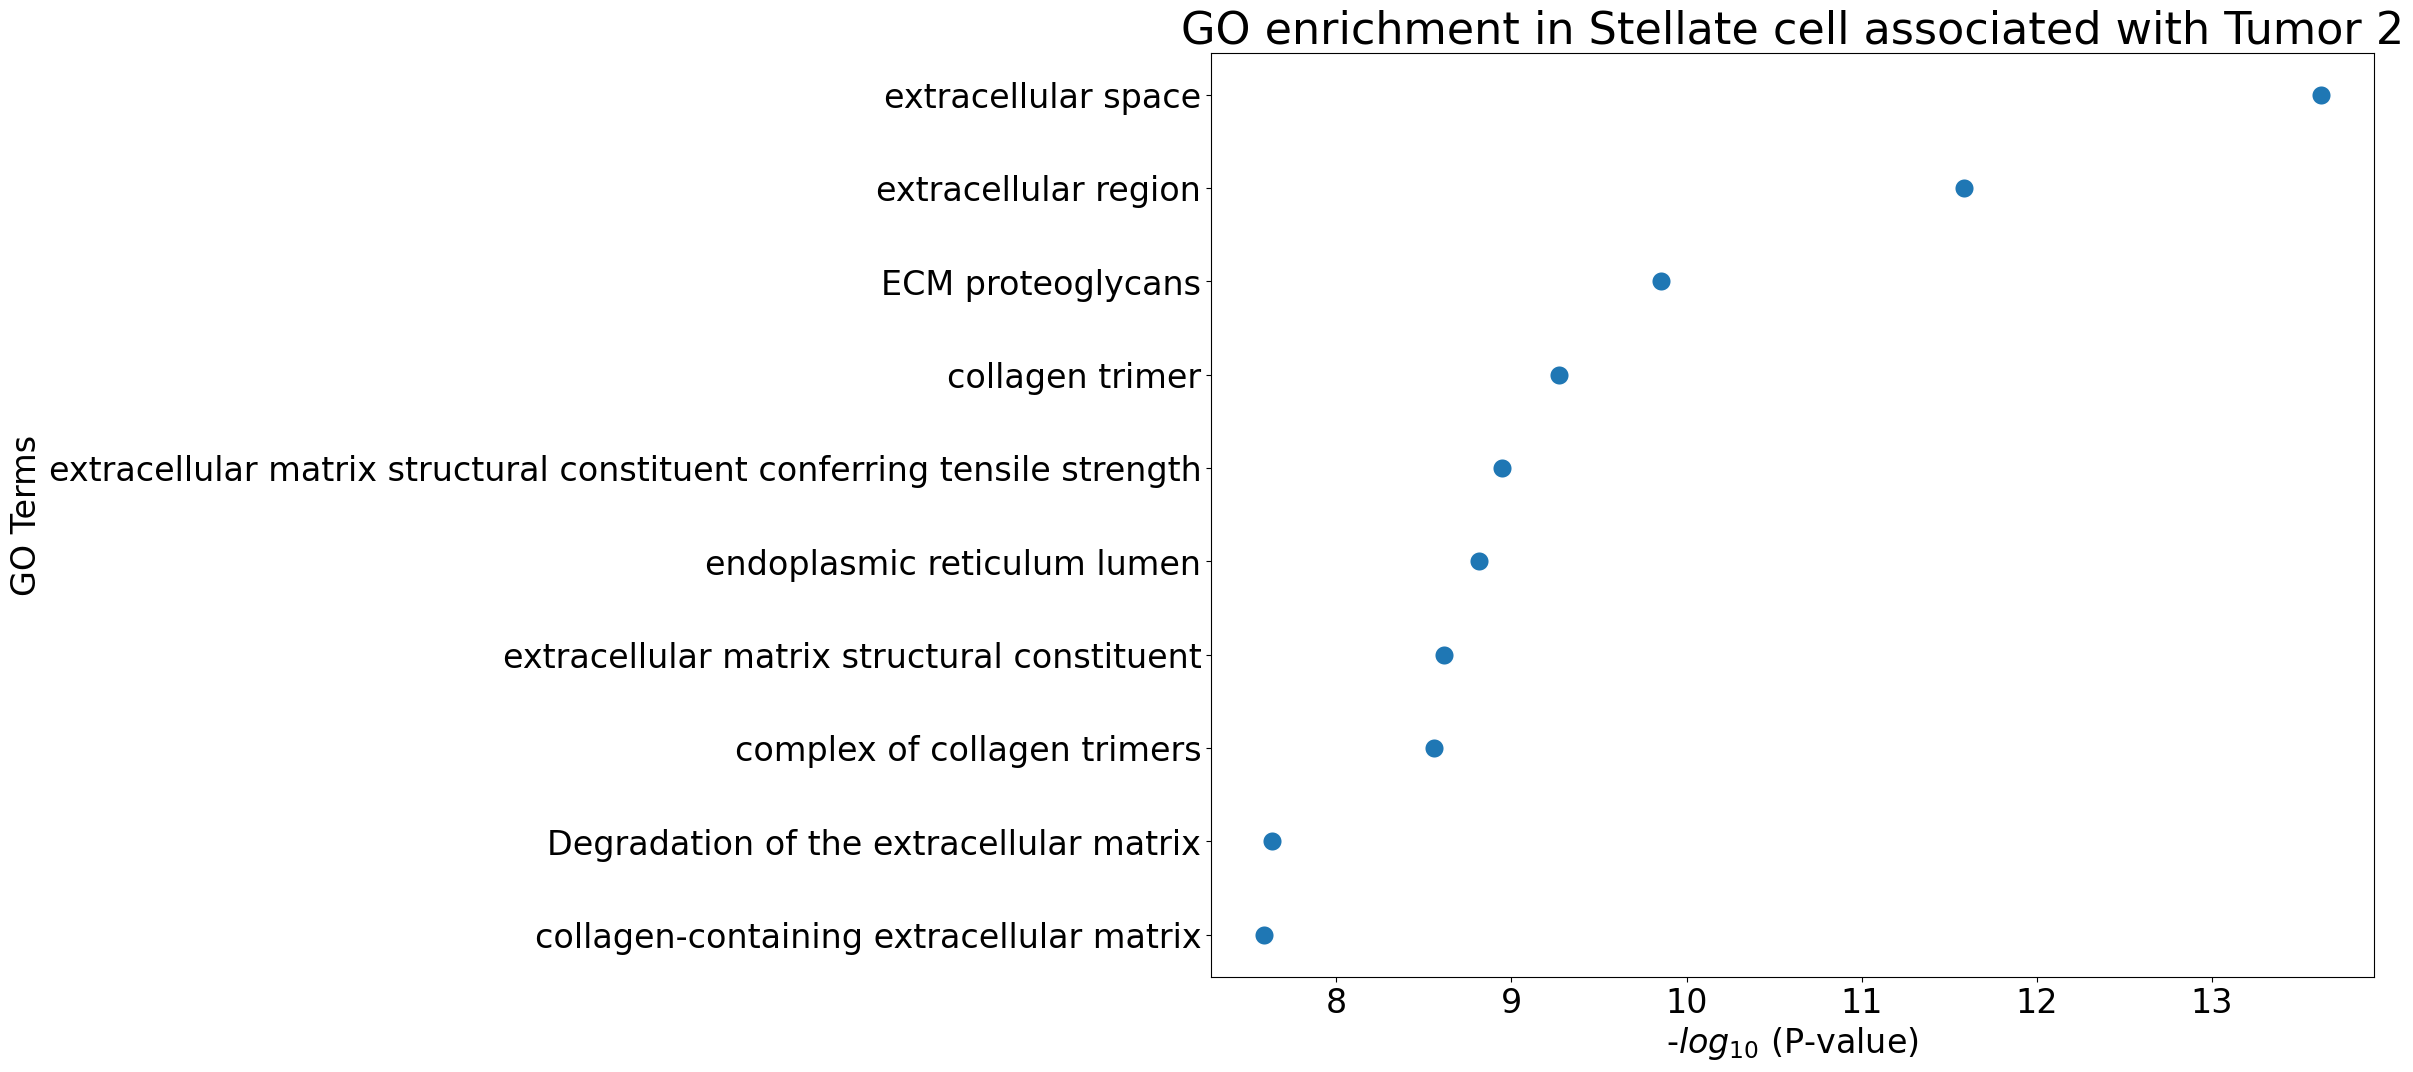

In [18]:
pl.pl.gene_annotation_cell_type_subgroup(cell_type = cell_type, group = 'Tumor 2',
                                  num_gos=10)

##### Ductal cell type 2

run limma lmFit
run limma eBayes


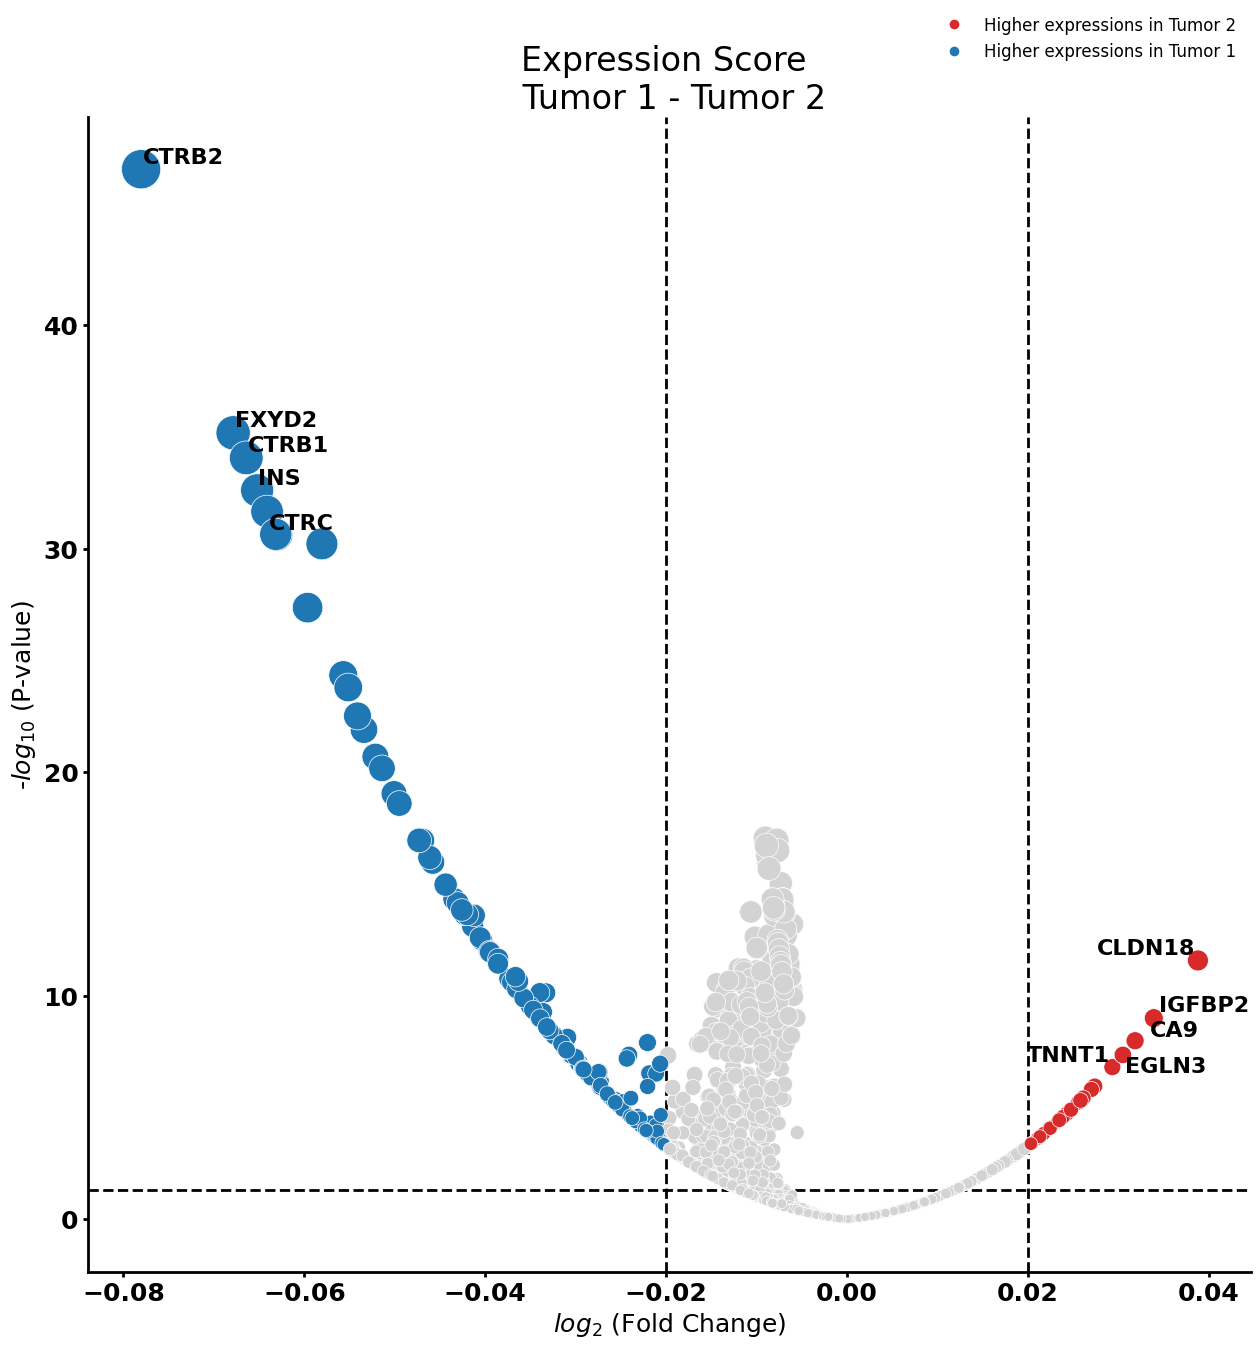

In [19]:
cell_type = "Ductal cell type 2" #look at the Cells folder
pl.tl.compute_diff_expressions(adata,cell_type, proportion_df,
                         fc_thr = 0.020, pval_thr = 0.05,
                         group1 = 'Tumor 1', group2 = 'Tumor 2',sample_col='sampleID',
                               col_cell='cell_types')

###### Gene Ontology analysis

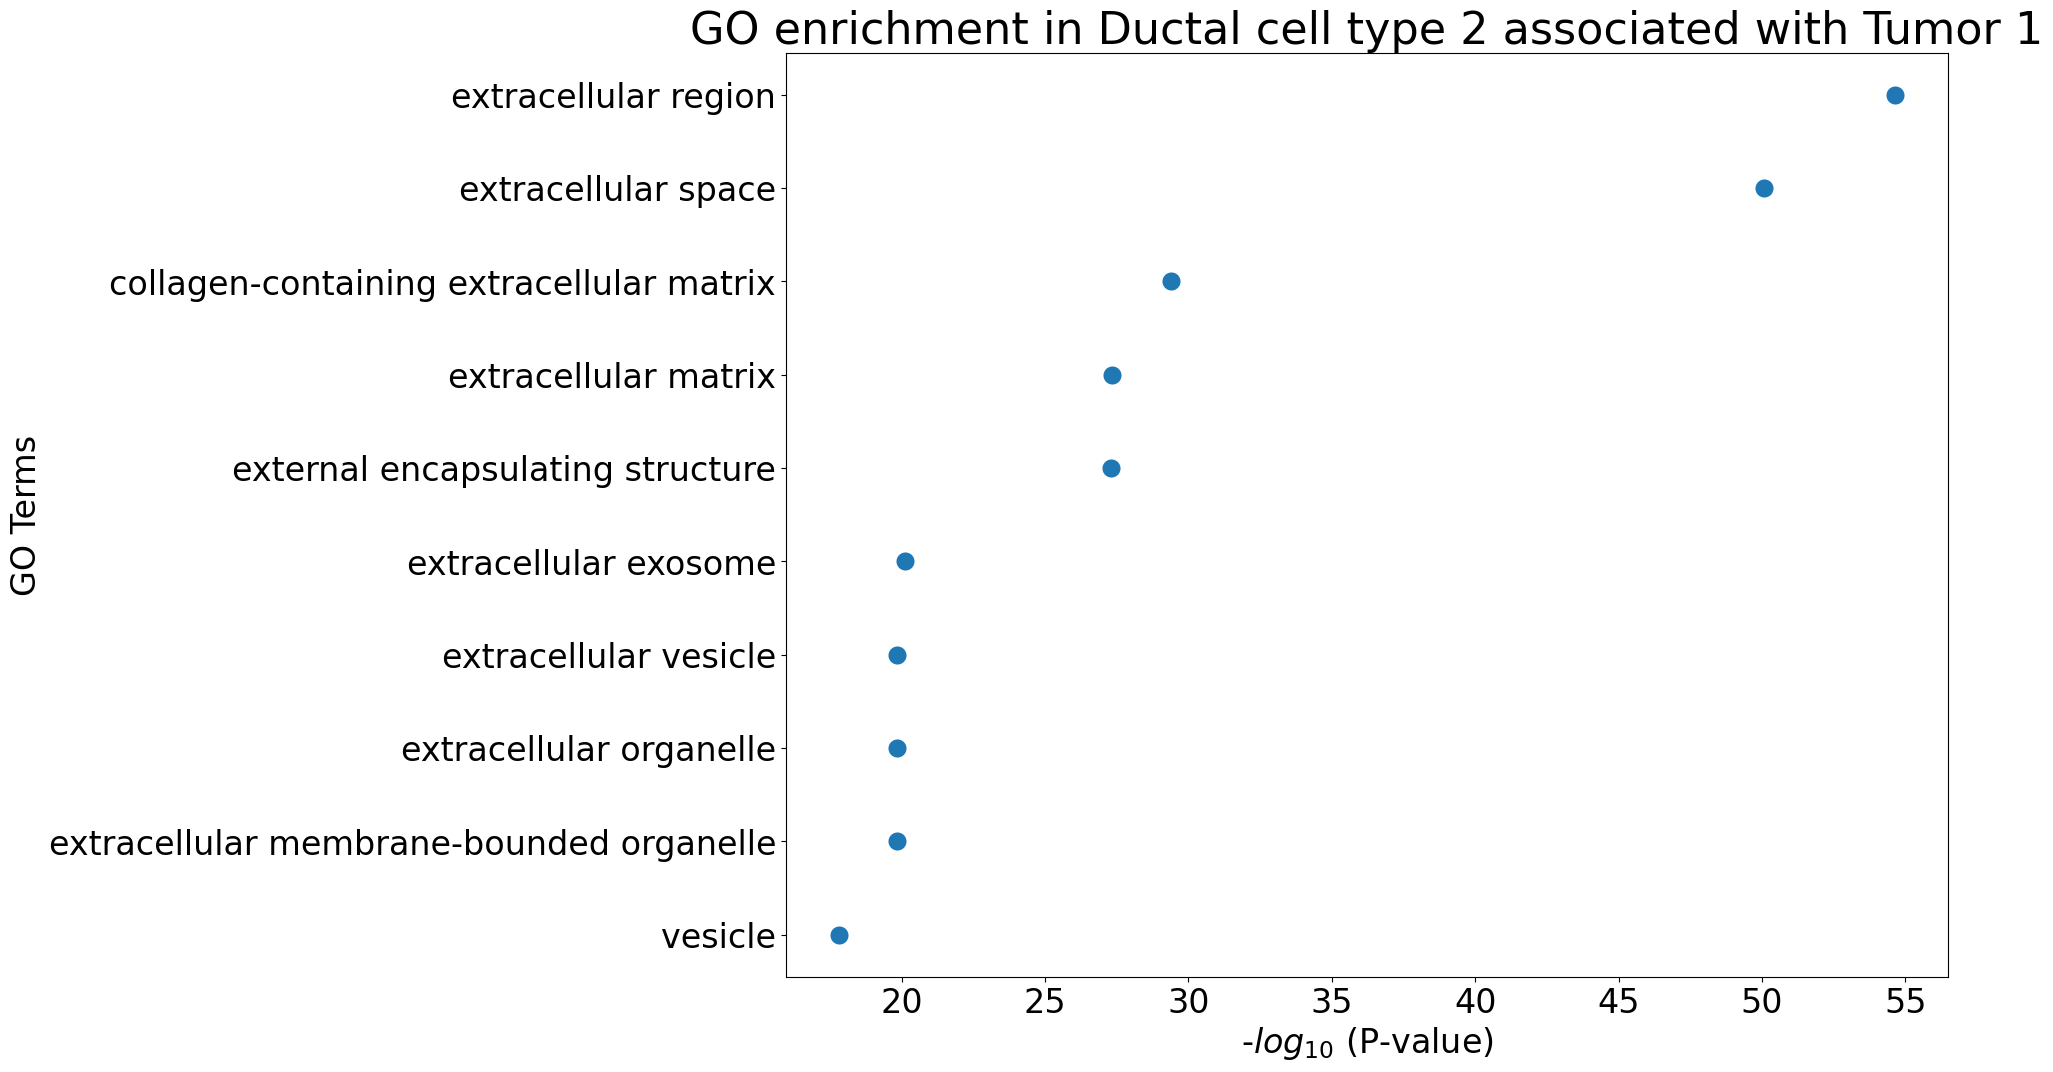

In [20]:
pl.pl.gene_annotation_cell_type_subgroup(cell_type = cell_type, group = 'Tumor 1',
                                   num_gos=10)

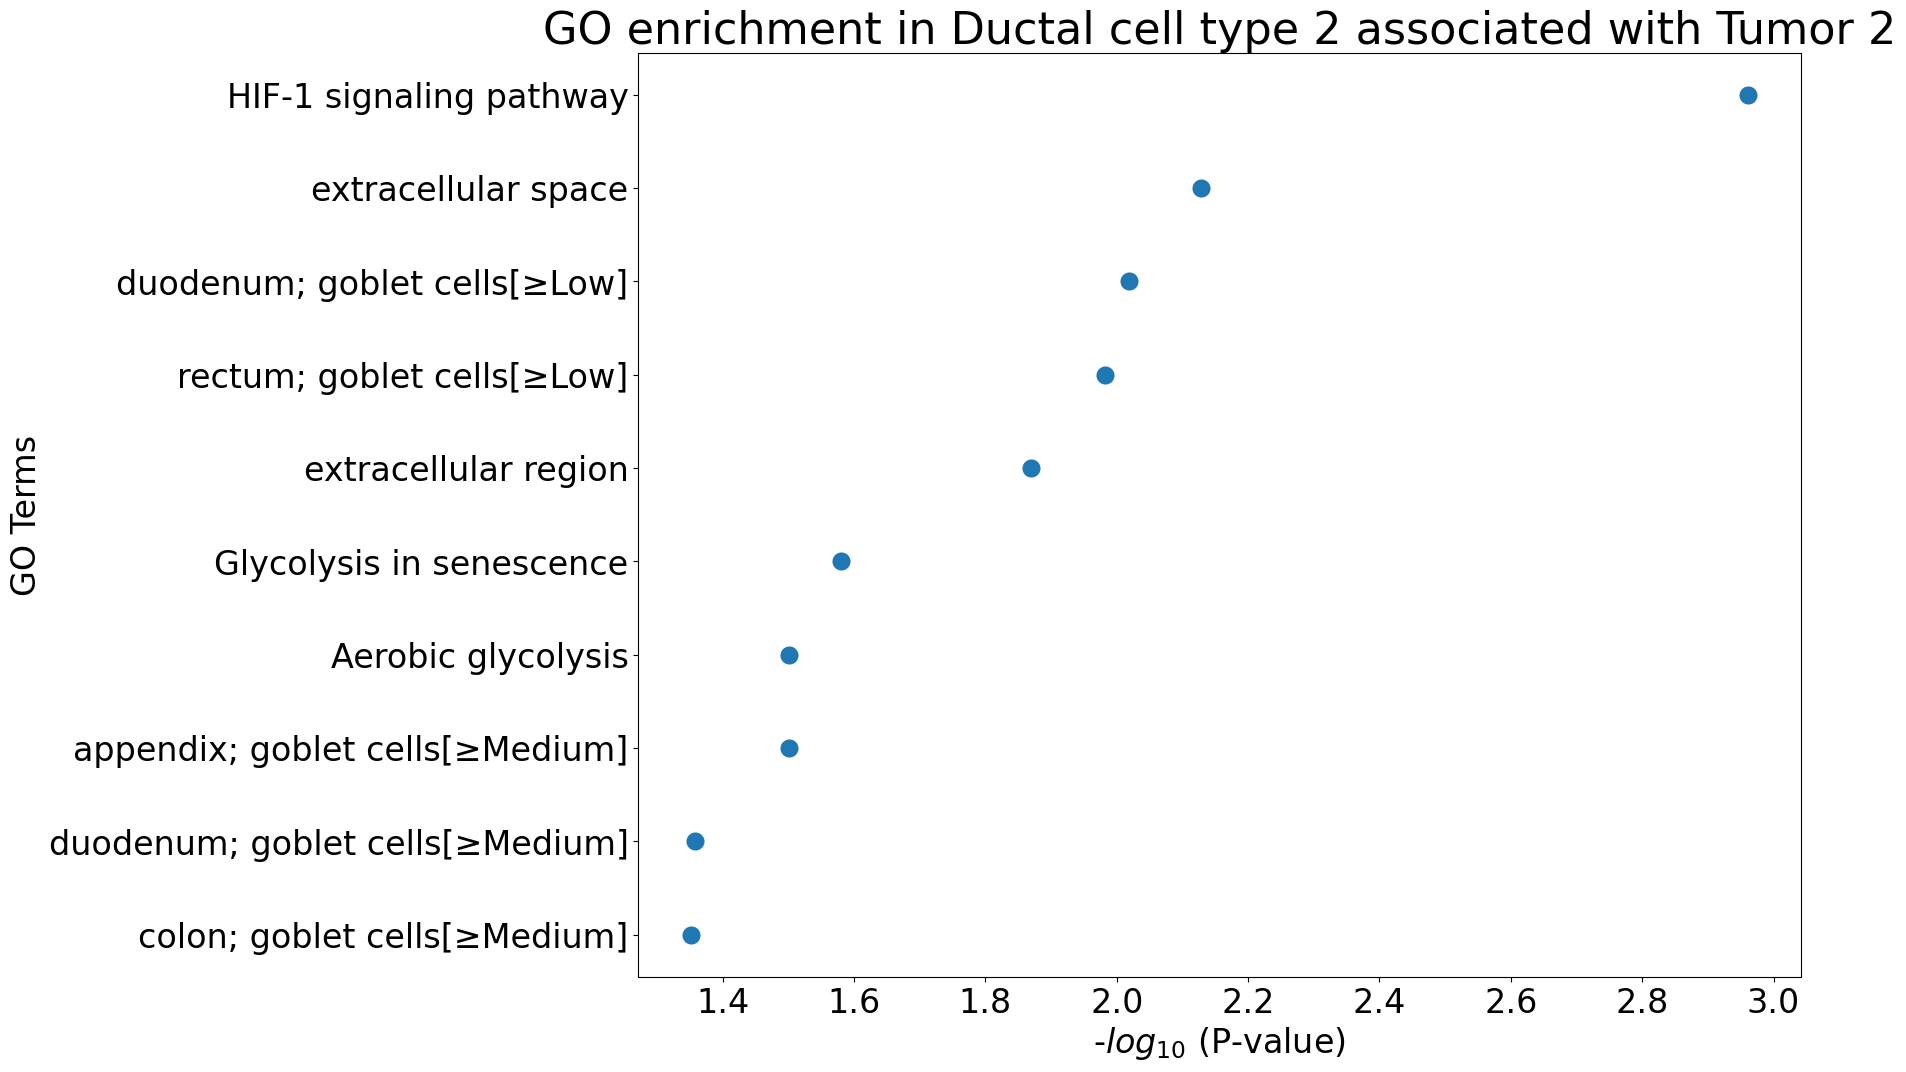

In [21]:
pl.pl.gene_annotation_cell_type_subgroup(cell_type = cell_type, group = 'Tumor 2',
                                   num_gos=10)